In [4]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from tqdm.notebook import tqdm
from IPython.display import Audio
from scipy.fftpack import dct
from scipy.signal import get_window

In [5]:
SR = 22500
FMIN = 0
FMAX = 11250
N_MELS = 128
N_MFCC = 40
N_FFT = 1024
HOP_LENGTH = 512
WINDOW_SIZE_MS = 1000 # seconds
DATA_DIR = 'data'
PAD_MODE = 'constant'
CENTER = True
FRAME_COUNT = 32
STRIDE_SIZE_MS = 500

def split_audio(audio_path: str, window_size_ms: float, stride_size_ms: float, sr: int = 16000) -> list:
    """
    Splits an audio file into overlapping windows based on window size and stride in milliseconds.

    Parameters
    ----------
    audio_path : str
        Path to the input .wav audio file.
    window_size_ms : float
        Size of each window in milliseconds.
    stride_size_ms : float
        Stride (hop) size between consecutive windows in milliseconds.
        Determines the overlap as overlap = window_size_ms - stride_size_ms.
    sr : int, optional
        Sampling rate for loading the audio. If None, uses the file's original sampling rate.

    Returns
    -------
    windows : list of np.ndarray
        List containing audio windows as numpy arrays, each padded to `window_size_ms` if necessary.
    """
    # Load audio
    y, sr = librosa.load(audio_path, sr=sr)

    # Ensure the audio is mono
    if y.ndim > 1:
        y = librosa.to_mono(y)

    # Convert window and stride sizes from milliseconds to samples
    window_length = int((window_size_ms / 1000) * sr)
    stride_length = int((stride_size_ms / 1000) * sr)

    # Total number of windows
    num_windows = int(np.ceil((len(y) - window_length) / stride_length)) + 1

    windows = []
    for i in range(num_windows):
        start = i * stride_length
        end = start + window_length
        window = y[start:end]

        # If the window is shorter than window_length, pad it with zeros
        if len(window) < window_length:
            padding = window_length - len(window)
            window = np.pad(window, (0, padding), mode='constant')

        windows.append(window)

    return windows

def extract_mfcc(window):
    # Compute MFCC
    mfcc = librosa.feature.mfcc(
        y=window, 
        sr=SR, 
        S=None,
        n_mfcc=N_MFCC,   
        dct_type=2, 
        norm='ortho', 
        lifter=0,
        # **kwargs: melspectogram
        n_fft=N_FFT,  
        hop_length=HOP_LENGTH, 
        window=get_window('hann', 1024),
        center=CENTER,  
        pad_mode=PAD_MODE,
        power=2.0,
        # **kwargs: mel filterbank
        n_mels=N_MELS,
        fmin=FMIN, 
        fmax=FMAX,
        htk=False,
    )
    return mfcc

def get_the_ith_file(path, i):
    return os.path.join(path, os.listdir(path)[i])

def plot_mfcc(path):
    windows = split_audio(path)
    for i, window in enumerate(windows):
        mfcc = extract_mfcc(window)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfcc, x_axis='time')
        plt.colorbar()
        plt.title(f'MFCC {i}')
        plt.tight_layout()
        plt.show()
        
def plot_audio_segments(audio_path, window_size_ms, stride_size_ms, sr):
    """
    Plot the full audio waveform with highlighted segments representing the split_audio function.
    """
    # Load the full audio
    y, sr = librosa.load(audio_path, sr=sr)

    # Calculate window size and stride in samples
    window_length = int((window_size_ms / 1000) * sr)
    stride_length = int((stride_size_ms / 1000) * sr)

    # Generate window start and end points
    num_windows = int(np.ceil((len(y) - window_length) / stride_length)) + 1
    windows = [(i * stride_length, i * stride_length + window_length) for i in range(num_windows)]

    # Plot the full waveform
    plt.figure(figsize=(15, 6))
    librosa.display.waveshow(y, sr=sr, alpha=0.5)
    plt.title("Audio Waveform with Segments (split_audio)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Highlight segments
    for i, (start, end) in enumerate(windows):
        plt.axvspan(start / sr, end / sr, color='red', alpha=0.2, label=f"Segment {i}" if i == 0 else None)
    
    # Add labels above each segment
    for i, (start, end) in enumerate(windows):
        plt.text((start + end) / (2 * sr), max(y) * 0.8, f"Seg {i}", color='blue', ha='center')

    # Add legend
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
def is_silent(window, threshold=0.01):
    """
    Checks if the given audio window is silent based on RMS energy.
    
    Parameters:
    - window: np.ndarray, the audio window
    - threshold: float, the RMS threshold below which the window is considered silent
    
    Returns:
    - True if the window is silent, False otherwise
    """
    rms = np.sqrt(np.mean(window ** 2))  # Calculate RMS energy
    return rms < threshold

def is_speech_spectral(window, sr, flux_threshold=0.02):
    """
    Filters speech-like windows based on spectral flux.

    Parameters:
    - window: np.ndarray, the audio window
    - sr: int, sampling rate
    - flux_threshold: float, threshold for spectral flux

    Returns:
    - True if the window is speech-like, False otherwise
    """
    stft = np.abs(librosa.stft(window, n_fft=1024, hop_length=512))
    spectral_flux = np.sum(np.sqrt(np.sum(np.diff(stft, axis=1)**2, axis=0)))
    return spectral_flux < flux_threshold  # Low flux indicates speech

def is_speech_zcr(window, zcr_threshold=0.1):
    """
    Filters speech-like windows based on zero-crossing rate.

    Parameters:
    - window: np.ndarray, audio window
    - zcr_threshold: float, threshold for ZCR

    Returns:
    - True if the window is speech-like, False otherwise
    """
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=window))
    return zcr < zcr_threshold  # Lower ZCR indicates speech

In [50]:
# Play audio segments
# test_audio_file = 'data/coughs/audioset_11.wav' # low background noise followed by short coughing
# test_audio_file = 'data/coughs/audioset_9.wav' # coughing
# test_audio_file = 'data/coughs/audioset_1.wav' # commercial with coughing
# test_audio_file = 'data/coughs/audioset_39.wav' # silence followed by coughing
# test_audio_file = 'data/coughs/audioset_106.wav' # silence followed by coughing
# test_audio_file = 'data/coughs/audioset_22.wav' # old man coughing with tv sound
test_audio_file = 'sample1.wav' # me coughing

# test_audio_file = 'data/not_coughs/audioset_12.wav' # conversation

test_windows = split_audio(test_audio_file, WINDOW_SIZE_MS, STRIDE_SIZE_MS, SR)
print(f'Number of test_windows: {len(test_windows)}')
Audio(test_audio_file, rate=SR)

Number of test_windows: 7


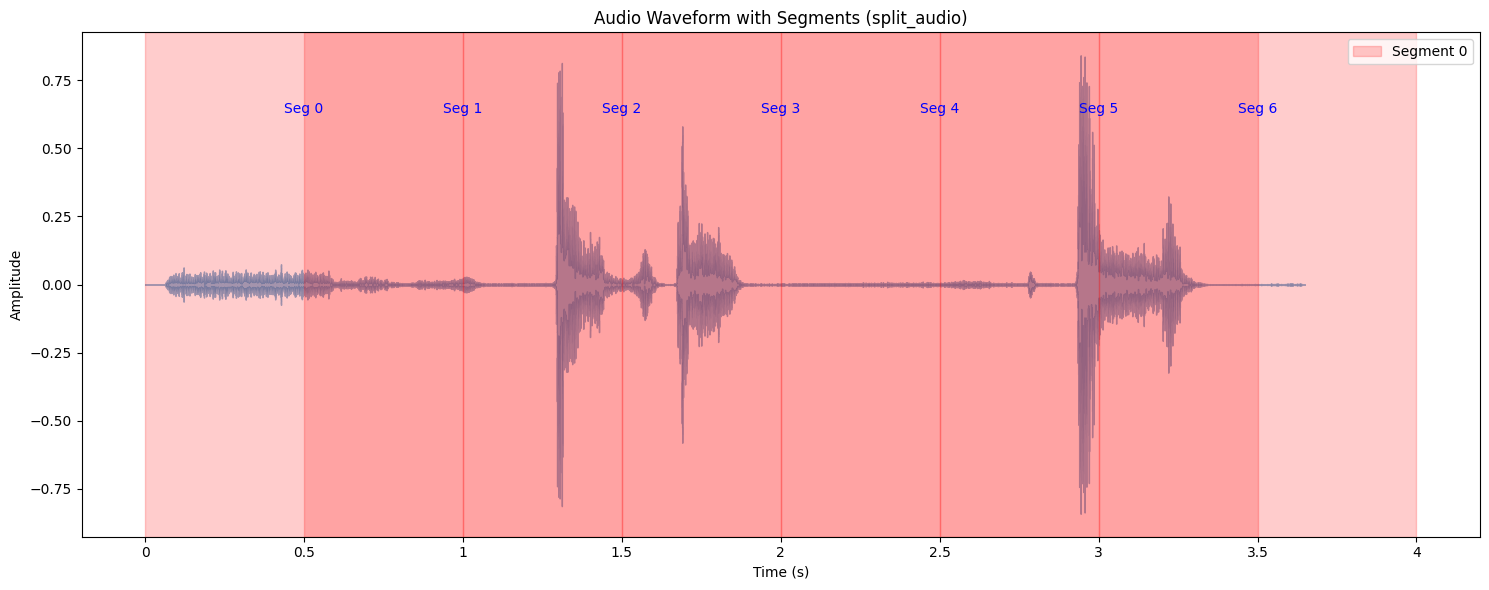

In [51]:
plot_audio_segments(test_audio_file, WINDOW_SIZE_MS, STRIDE_SIZE_MS, SR)

In [52]:
# Test Cough Window Filters on All Test Windows
for i, window in enumerate(test_windows):
    print(f"Window {i}:")
    print(f"Silent: {is_silent(window)}")
    print(f"Spectral: {is_speech_spectral(window, SR)}")
    print(f"ZCR: {is_speech_zcr(window)}")
    print()

Window 0:
Silent: False
Spectral: False
ZCR: False

Window 1:
Silent: False
Spectral: False
ZCR: False

Window 2:
Silent: False
Spectral: False
ZCR: False

Window 3:
Silent: False
Spectral: False
ZCR: False

Window 4:
Silent: False
Spectral: False
ZCR: False

Window 5:
Silent: False
Spectral: False
ZCR: False

Window 6:
Silent: False
Spectral: False
ZCR: False



In [6]:
# Variables to store data
mfccs = []
labels = []
gl_coughs_count = 0
gl_non_coughs_count = 0

# List of filters for cough window cleaning
filters = [
    lambda w: is_silent(w),
    lambda w: is_speech_spectral(w, SR),
    lambda w: is_speech_zcr(w),
]

# Return True if it needs to be filtered out, False otherwise
def filter_window(window, filters):
    for f in filters:
        if f(window):
            return True
    return False

In [7]:
# Limiters
N_COUGHS = -1           # Number of coughs to extract from each audio file. Set to -1 to extract all coughs.
N_NON_COUGHS = 1200     # Number of non-coughs to extract from each audio file. Set to -1 to extract all non-coughs. was 1200
first_dataset_cough_count = 0
first_dataset_non_cough_count = 0

# Load the first data set (https://www.kaggle.com/datasets/himanshu007121/cough-audio-dataset)
cough_dir = os.path.join(DATA_DIR, 'coughs')
non_cough_dir = os.path.join(DATA_DIR, 'not_coughs')

# Load coughs
cough_files = os.listdir(cough_dir)

for cough_file in tqdm(cough_files, desc='Loading coughs'):
    # Check if we have reached the desired number of coughs
    if first_dataset_cough_count == N_COUGHS and N_COUGHS != -1:
        print("Coughs count reached")
        break

    # Load the audio file
    cough_path = os.path.join(cough_dir, cough_file)
    windows = split_audio(cough_path, WINDOW_SIZE_MS, STRIDE_SIZE_MS, SR)
    # for window in windows:
    #     mfcc = extract_mfcc(window)
    #     mfccs.append(mfcc)
    #     labels.append(1)

    for window in windows:
        # If the window passes all filters, add it to the dataset
        if filter_window(window, filters):
            mfccs.append(extract_mfcc(window))
            labels.append(0)
        else:
            mfccs.append(extract_mfcc(window))
            labels.append(1)

    gl_coughs_count += 1
    first_dataset_cough_count += 1

# Load non-coughs
non_cough_files = os.listdir(non_cough_dir)

for non_cough_file in tqdm(non_cough_files, desc='Loading non-coughs'):
    # Check if we have reached the desired number of non-coughs
    if first_dataset_non_cough_count == N_NON_COUGHS and N_NON_COUGHS != -1:
        print("Non coughs count reached")
        break
    
    # Load the audio file
    non_cough_path = os.path.join(non_cough_dir, non_cough_file)
    windows = split_audio(non_cough_path, WINDOW_SIZE_MS, STRIDE_SIZE_MS, SR)
    for window in windows:
        mfcc = extract_mfcc(window)
        mfccs.append(mfcc)
        labels.append(0)
    gl_non_coughs_count += 1
    first_dataset_non_cough_count += 1

# Make sure all MFCCs have the same shape
for mfcc in mfccs:
    assert mfcc.shape == mfccs[0].shape, 'All MFCCs should have the same shape'

Loading coughs:   0%|          | 0/431 [00:00<?, ?it/s]

Loading non-coughs:   0%|          | 0/12813 [00:00<?, ?it/s]

Non coughs count reached


In [8]:
# Constants
N_COUGHS_COUGHVID = 6500          # Number of coughs to extract from each audio file. Set to -1 to extract all coughs. was 4500
N_NON_COUGHS_COUGHVID = 3200      # Number of non-coughs to extract from each audio file. Set to -1 to extract all non-coughs. was 2800
coughvid_coughs_count = 0
coughvid_non_coughs_count = 0

# Confidence Threshold
THRESHOLD = 0.1

# Skip Flags
skip_coughs = False
skip_non_coughs = False

# Load Dataset from COUGHVID-19 dataset (https://www.kaggle.com/datasets/nasrulhakim86/coughvid-wav)
COUGHVID_DIR = os.path.join(DATA_DIR, 'coughvid')

wav_files = [file for file in os.listdir(COUGHVID_DIR) if file.endswith('.wav')]
json_files = [file for file in os.listdir(COUGHVID_DIR) if file.endswith('.json')]

for wav_file in tqdm(wav_files, desc='Loading COUGHVID dataset'):
    if skip_coughs and skip_non_coughs:
        break

    # Find the corresponding JSON file
    json_file = wav_file.replace('.wav', '.json')
    json_path = os.path.join(COUGHVID_DIR, json_file)

    # Check if the JSON file exists
    if not os.path.exists(json_path):
        # Skip the file if no JSON file is found
        print(f'No JSON file found for {wav_file}, skipping...')
        continue

    # Load JSON
    with open(json_path, 'r') as f:
        data = json.load(f)
        confidence = float(data['cough_detected'])

    # Check if it's a cough or not
    if confidence > 1-THRESHOLD:        # if confidence = 0.1, then confidence > 0.9
        if skip_coughs:
            continue

        # Check if limit is reached
        if coughvid_coughs_count == N_COUGHS_COUGHVID and N_COUGHS_COUGHVID != -1:
            print("Coughs count reached")
            skip_coughs = True
            continue

        # Preprocess the audio
        windows = split_audio(os.path.join(COUGHVID_DIR, wav_file), WINDOW_SIZE_MS, STRIDE_SIZE_MS, SR)
        # for window in windows:
        #     mfcc = extract_mfcc(window)
        #     mfccs.append(mfcc)
        #     labels.append(1)
        for window in windows:
            # If the window passes all filters, add it to the dataset
            if filter_window(window, filters):
                mfccs.append(extract_mfcc(window))
                labels.append(0)
            else:
                mfccs.append(extract_mfcc(window))
                labels.append(1)
        gl_coughs_count += 1
        coughvid_coughs_count += 1

    elif confidence < THRESHOLD:    # if confidence = 0.1, then confidence < 0.1
        if skip_non_coughs:
            continue

        # Check if limit is reached
        if coughvid_non_coughs_count == N_NON_COUGHS_COUGHVID and N_NON_COUGHS_COUGHVID != -1:
            print("Non coughs count reached")
            skip_non_coughs = True
            continue

        # Preprocess the audio
        windows = split_audio(os.path.join(COUGHVID_DIR, wav_file), WINDOW_SIZE_MS, STRIDE_SIZE_MS, SR)
        for window in windows:
            mfcc = extract_mfcc(window)
            mfccs.append(mfcc)
            labels.append(0)
        gl_non_coughs_count += 1
        coughvid_non_coughs_count += 1
        
# Make sure all MFCCs have the same shape
for mfcc in mfccs:
    assert mfcc.shape == mfccs[0].shape, 'All MFCCs should have the same shape'

Loading COUGHVID dataset:   0%|          | 0/27550 [00:00<?, ?it/s]

Coughs count reached
Non coughs count reached


In [9]:
# Print the number of coughs and non-coughs
print(f'Number of coughs: {gl_coughs_count}')
print(f'Number of non-coughs: {gl_non_coughs_count}')
print(f'MFCC shape: {mfccs[0].shape}')

Number of coughs: 6931
Number of non-coughs: 4400
MFCC shape: (40, 44)


In [10]:
from sklearn.preprocessing import StandardScaler

# Scale the data
mfccs_np = np.array(mfccs)

# Flatten the data and scale it
n_samples, n_mfccs, n_frames = mfccs_np.shape
mfccs_flat = mfccs_np.reshape(n_samples, -1)
scaler = StandardScaler()
mfccs_scaled_flat = scaler.fit_transform(mfccs_flat)

# Reshape the data
mfccs_scaled_standard = mfccs_scaled_flat.reshape(n_samples, n_mfccs, n_frames)

# Print the mean values
print("Means:")
print(scaler.mean_)
print(scaler.mean_.shape)

# Print the standard deviations
print("Standard Deviations:")
print(scaler.scale_)
print(scaler.scale_.shape)

Means:
[-6.73770041e+02 -6.65200687e+02 -6.63948571e+02 ...  3.76006827e-01
  3.53895780e-01  3.52122165e-01]
(1760,)
Standard Deviations:
[304.14360712 294.97892277 294.57327759 ...   4.95341402   4.92960155
   4.91483483]
(1760,)


In [11]:
# Split the Data
from sklearn.model_selection import train_test_split

# Split data to training and testing
X_train, X_test, y_train, y_test = train_test_split(mfccs_scaled_standard, labels, test_size=0.2, random_state=42)

# Further split the training data to training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print out the shapes
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')
print(f'Validation data shape: {X_val.shape}')


Training data shape: (107769, 40, 44)
Testing data shape: (33679, 40, 44)
Validation data shape: (26943, 40, 44)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Prepare the data
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [13]:
# Define new, more complex model
def create_model(input_shape):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    # Second Convolutional Block
    model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    # Flatten the output of the previous layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Create the model
model = create_model(input_shape=(X_train.shape[1], X_train.shape[2], 1))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

C:\Users\Enrique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 44, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 22, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 22, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 22, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 11, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 11, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 880)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 880)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        56,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,785 (221.82 KB)

 Trainable params: 56,785 (221.82 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Model Checkpoint
model_checkpoint = ModelCheckpoint(
    'best_cough_detection_model_final.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Fit the model
history_complex = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    verbose=1,
    callbacks=[model_checkpoint]
)

Epoch 1/50
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.7729 - loss: 0.4738 - val_accuracy: 0.8757 - val_loss: 0.3220
Epoch 2/50
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - accuracy: 0.8498 - loss: 0.3201 - val_accuracy: 0.8843 - val_loss: 0.3011
Epoch 3/50
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - accuracy: 0.8596 - loss: 0.3008 - val_accuracy: 0.8883 - val_loss: 0.2819
Epoch 4/50
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.8664 - loss: 0.2902 - val_accuracy: 0.8881 - val_loss: 0.2786
Epoch 5/50
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.8722 - loss: 0.2815 - val_accuracy: 0.8940 - val_loss: 0.2624
Epoch 6/50
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.8763 - loss: 0.2716 - val_accuracy: 0.8890 - val_loss: 0.2720
Epoch 7/50
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8778 - loss: 0.2683 - val_accuracy: 0.8902 - val_loss: 0.2495
Epoch 8/50
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8779 - 

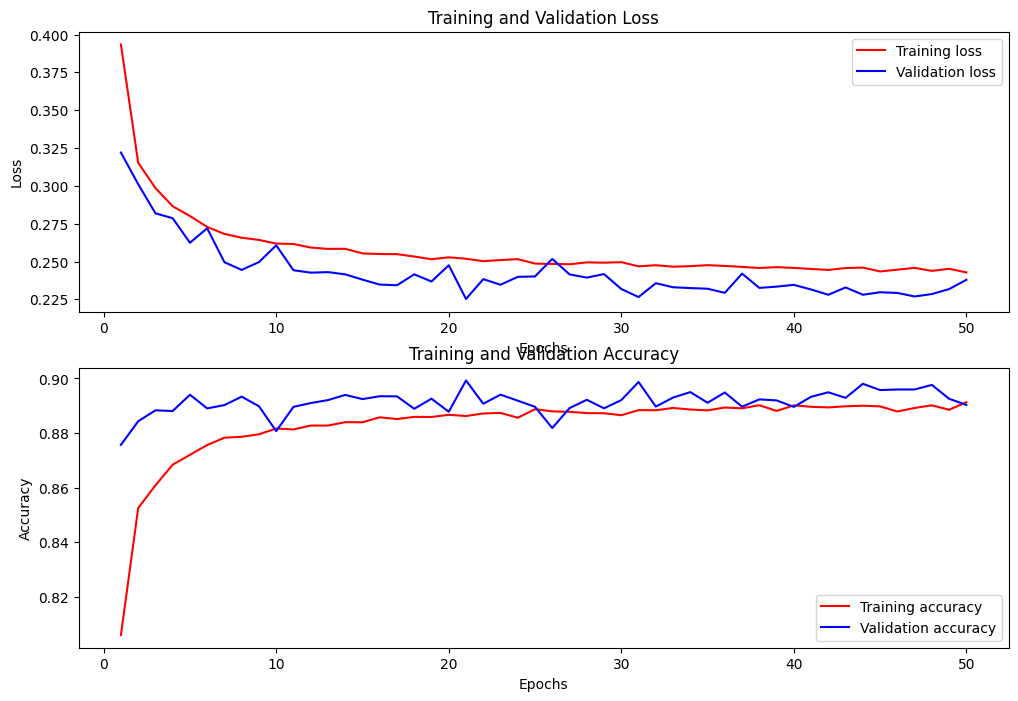

In [15]:
# Plot the training history
history_dict_complex = history_complex.history
loss_values_complex = history_dict_complex['loss']
val_loss_values_complex = history_dict_complex['val_loss']
acc_values_complex = history_dict_complex['accuracy']
val_acc_values_complex = history_dict_complex['val_accuracy']
epochs_complex = range(1, len(loss_values_complex) + 1)

# Create a figure with subplots
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(epochs_complex, loss_values_complex, "r", label="Training loss")
plt.plot(epochs_complex, val_loss_values_complex, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(epochs_complex, acc_values_complex, "r", label="Training accuracy")
plt.plot(epochs_complex, val_acc_values_complex, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [16]:
# Test the model
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
print(X_test.shape)
test_loss_complex, test_accuracy_complex = model.evaluate(X_test, y_test)

(33679, 40, 44)
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8899 - loss: 0.2388


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Add channel dimension to X_test
X_test_new = np.expand_dims(X_test, axis=-1)  # Add a batch dimension if needed

# Make predictions
y_pred_complex = model.predict(X_test_new)

# Convert predictions to binary (threshold at 0.5)
y_pred_complex_binary = (y_pred_complex > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_complex_binary, target_names=['Non-Cough', 'Cough']))

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

   Non-Cough       0.97      0.88      0.92     25193
       Cough       0.73      0.91      0.81      8486

    accuracy                           0.89     33679
   macro avg       0.85      0.90      0.87     33679
weighted avg       0.91      0.89      0.89     33679



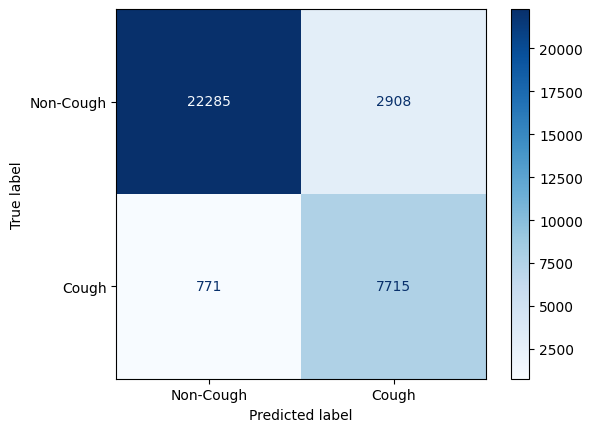

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_complex_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cough', 'Cough'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [55]:
# Try to predict the label of the first test sample
# filename = os.path.join(COUGHVID_DIR, 'ffba4301-066a-4675-9548-34e7f5e758bf.wav') # cough
# filename = os.path.join(COUGHVID_DIR, 'ff8363d2-016d-4738-9499-4c62480886fb.wav') # cough
filename = 'sample1.wav' # cough
# filename = 'sample2.wav' # non-cough
# filename = os.path.join(COUGHVID_DIR, 'ff8300c7-fded-4ed0-b396-635f90d9b262.wav') # non-cough
# filename = os.path.join(COUGHVID_DIR, 'ff73ca29-4f61-42cf-9e3f-7e616da4cdde.wav') # non-cough continued by cough
# filename = os.path.join(non_cough_dir, 'fsd_1364.wav') # non-cough (applause sounds)

windows = split_audio(filename, WINDOW_SIZE_MS, STRIDE_SIZE_MS, SR)

for i, window in enumerate(windows):
    mfcc = extract_mfcc(window)
    mfcc_flat = mfcc.reshape(1, -1)
    mfcc_scaled = scaler.transform(mfcc_flat)
    mfcc_standard = mfcc_scaled.reshape(1, mfcc.shape[0], mfcc.shape[1], 1)
    prediction = model.predict(mfcc_standard)
    print(f'Prediction for window[{i}]: {prediction[0][0]}')

# Show the audio file
Audio(filename)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for window[0]: 0.49145975708961487
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for window[1]: 0.7075378894805908
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for window[2]: 0.7827579975128174
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for window[3]: 0.5898205041885376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for window[4]: 0.2649436295032501
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for window[5]: 0.7613486647605896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for window[6]: 0.7703514099121094


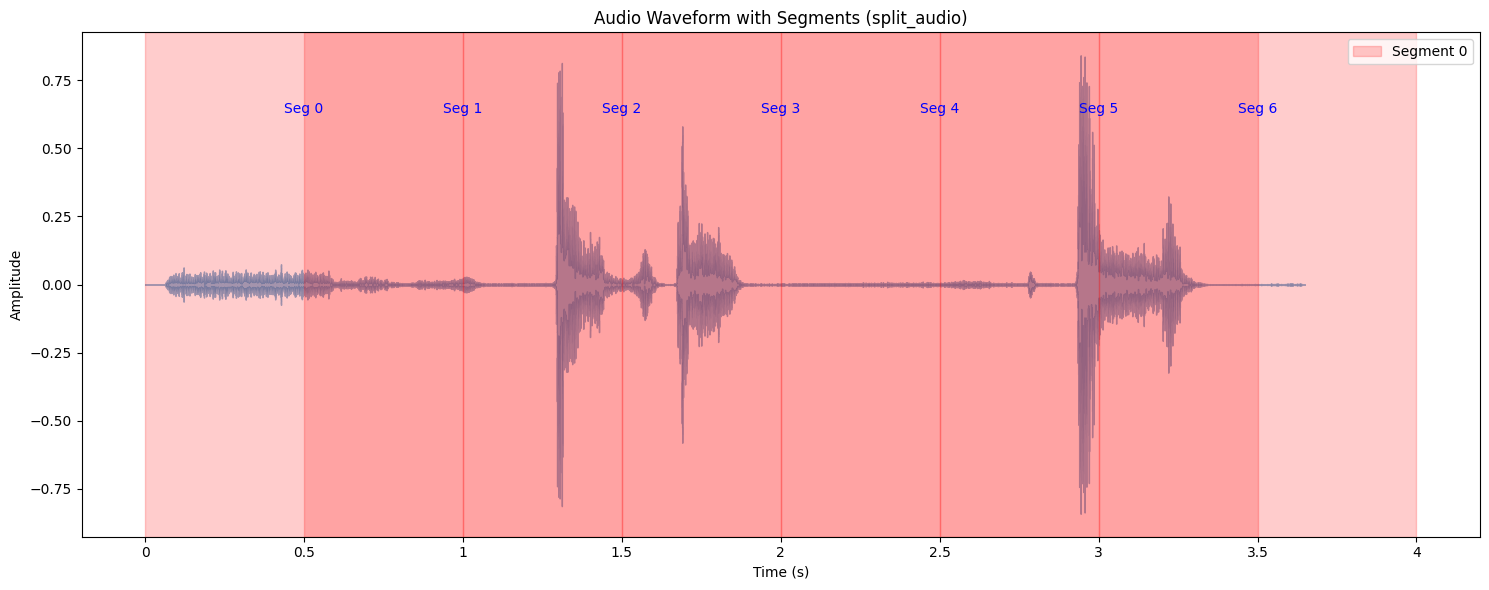

In [56]:
# Print Segmented Audio
plot_audio_segments(filename, WINDOW_SIZE_MS, STRIDE_SIZE_MS, SR)
Audio(windows[3], rate=SR)

In [20]:
# Export the model
model.save('model_final.keras')

import pickle
# Export the Scaler
with open('scaler_final.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save scaler metrics to a C++ header file
with open('scaler_final.h', 'w') as f:
    f.write("#ifndef SCALER_H\n")
    f.write("#define SCALER_H\n\n")
    
    f.write(f"const int N_MFCCS = {len(scaler.mean_)};\n\n")
    
    # Write mean array
    f.write("const float mfcc_mean[N_MFCCS] = {")
    f.write(", ".join([f"{m:.6f}" for m in scaler.mean_]))
    f.write("};\n\n")
    
    # Write std array
    f.write("const float mfcc_std[N_MFCCS] = {")
    f.write(", ".join([f"{s:.6f}" for s in scaler.scale_]))
    f.write("};\n\n")
    
    f.write("#endif // SCALER_H\n")


In [21]:
# Load Model Just to Make Sure
loaded_model = tf.keras.models.load_model('model_final.keras')

# Quantize
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)

# Define the representative dataset generator
combined_X = np.concatenate((X_train, X_test, X_val))
print(combined_X.shape)
def representative_dataset_gen():
    for i in range(0, len(combined_X), 100):
        # Extract one sample at a time with shape [1, 40, 32, 1]
        sample = combined_X[i:i+1]
        
        # If combined_X_train is a TensorFlow tensor, convert it to NumPy
        if isinstance(sample, tf.Tensor):
            sample = sample.numpy()
            
        # Add the channel dimension to make it [1, 40, 32, 1]
        sample = np.expand_dims(sample, axis=-1)
        
        # Ensure the sample is of type float32
        yield [sample.astype(np.float32)]

# Set the optimization flag to default, which enables post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Give a representative dataset
converter.representative_dataset = representative_dataset_gen

# Quantize Weights
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Convert the model
tflite_quant_model = converter.convert()

# Save the quantized model
with open("converted_model_final.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("Dynamic Range Quantization complete. Saved as 'final_model_quantized'")

(168391, 40, 44)
INFO:tensorflow:Assets written to: C:\Users\Enrique\AppData\Local\Temp\tmp1hhls2a3\assets


INFO:tensorflow:Assets written to: C:\Users\Enrique\AppData\Local\Temp\tmp1hhls2a3\assets


Saved artifact at 'C:\Users\Enrique\AppData\Local\Temp\tmp1hhls2a3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 44, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2301797071568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301797071952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301797059664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301816848656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301816853264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301816851920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301816852688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301816852496: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\Enrique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Dynamic Range Quantization complete. Saved as 'final_model_quantized'


In [ ]:
!xxd -i converted_model_16kHz.tflite > model_data_final.cc

## If You Have Downloaded The Model File (Both Quantized and Unquantized) Run the Two First Code Blocks At The Top And Run The Cells Below

In [8]:
# Compare Performance
import tensorflow as tf
import pickle

# Uncomment if you haven't already loaded the data
# DATA_DIR = 'data'
# cough_dir = os.path.join(DATA_DIR, 'coughs')
# non_cough_dir = os.path.join(DATA_DIR, 'not_coughs')
# COUGHVID_DIR = os.path.join(DATA_DIR, 'coughvid')

# Load the original Keras model
original_model = tf.keras.models.load_model('model_final.keras')

# Load the quantized TFLite model
interpreter = tf.lite.Interpreter(model_path="converted_model_final.tflite")
interpreter.allocate_tensors()

# Load the scaler
with open('scaler_final.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_filename = 'sample1.wav' # cough
input_windows = windows = split_audio(input_filename, WINDOW_SIZE_MS, STRIDE_SIZE_MS, SR)
print(f"Window Sizes: {np.array(input_windows).shape}")

print("Original Model")
for window in input_windows:
    mfcc = extract_mfcc(window)
    mfcc_flat = mfcc.reshape(1, -1)
    mfcc_scaled = scaler.transform(mfcc_flat)
    mfcc_standard = mfcc_scaled.reshape(1, mfcc.shape[0], mfcc.shape[1], 1)
    # print(f"Input Size: {mfcc_standard.shape}")
    prediction = original_model.predict(mfcc_standard)
    print(f'Prediction: {prediction[0][0]}')

print("\nTFLite Model")
for window in input_windows:
    mfcc = extract_mfcc(window)
    mfcc_flat = mfcc.reshape(1, -1)
    mfcc_scaled = scaler.transform(mfcc_flat)
    mfcc_standard = mfcc_scaled.reshape(1, mfcc.shape[0], mfcc.shape[1], 1)
    # print(f"Input Size: {mfcc_standard.shape}")
    # print(f"MFCC dtype: {mfcc_standard.dtype}")
    # Convert to float32
    mfcc_standard = mfcc_standard.astype(np.float32)

    # Get prediction from the quantized model
    interpreter.set_tensor(input_details[0]['index'], mfcc_standard)
    interpreter.invoke()
    quantized_pred = interpreter.get_tensor(output_details[0]['index'])
    print(f"Quantized Model Prediction: {quantized_pred[0][0]}")

Window Sizes: (7, 22500)
Original Model
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: 0.49145975708961487
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: 0.7075378894805908
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: 0.7827579975128174
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: 0.5898205041885376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: 0.2649436295032501
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: 0.7613486647605896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: 0.7703514099121094

TFLite Model
Quantized Model Prediction: 0.5
Quantized Model Prediction: 0.71484375
Quantized Model Prediction: 0.78515625
Quantized Model Prediction: 0.59765625
Quantized Model Prediction: 0.26171875
Quantized Model Prediction: 0.76171875
Quantized Model Prediction: 0.7734375


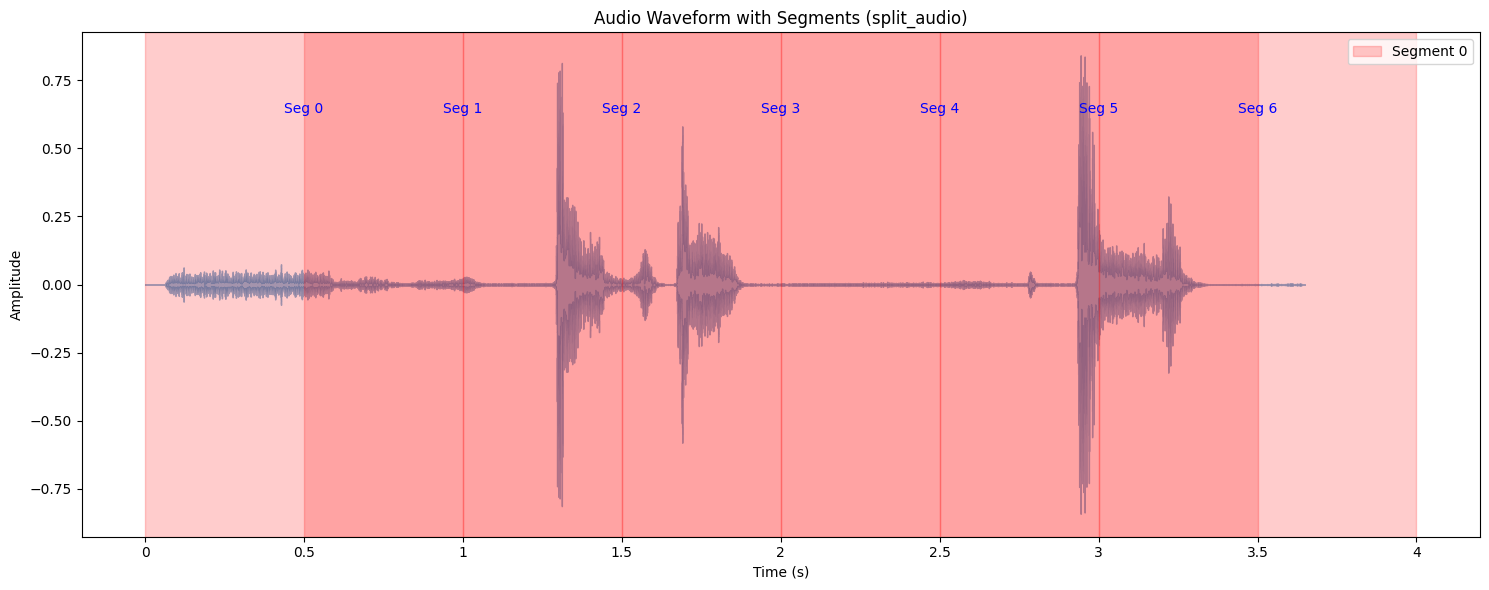

In [10]:
window_index = 1

# Print segmented audio
plot_audio_segments(input_filename, WINDOW_SIZE_MS, STRIDE_SIZE_MS, SR)

Audio(input_windows[window_index], rate=SR)